<style>
/* Reveal container full viewport */
.reveal {
  width: 95vw !important; /* 95% of view width */
  height: 50vw !important;   /* about 16:9 aspect ratio height (width × 9/16) */
  max-width: 95vw !important;
  max-height: 50vw !important;
  margin: auto;
  font-size: 110%; /* global font size */
}

/* Slides filling container */
.reveal .slides {
  width: 100% !important;
  height: 100% !important;
  max-width: 100% !important;
  max-height: 100% !important;
  margin: auto;
  overflow-wrap: break-word;
}

/* Prevent content from overflowing horizontally */
.reveal section {
  overflow-x: auto;
  word-wrap: break-word;
  box-sizing: border-box;
  padding: 1em;
}

/* Tables scroll horizontally if too wide */
.reveal section table {
  display: block;
  overflow-x: auto;
  white-space: nowrap;
  max-width: 100%;
  margin: 0 auto;
  font-size: 90%;
  border-collapse: collapse;
}

/* Smaller font and compact padding inside table cells */
.reveal section table td,
.reveal section table th {
  font-size: 90%;
  padding: 0.3em 0.5em;
  white-space: nowrap;
}
</style>

# First Hands-On Session
---
Introducing basic concepts by tracking one or few particles

---

## 🐍 Python corner

Let's import standard packages, settings, and custom functions from the [tracking_library.py](./tracking_library.py).
- `numpy` as `np`
- `matplotlib.pyplot` as `plt`
- functions `D`, `Q`, `transportParticles`, `getEquivalentElement`

In [1]:
# Import custom functions and useful libraries (like numpy, matplotlib, etc.)
from tracking_library import *

In this notebook we will need only these custom functions:

| Description                                                       | Syntax                    | Returns                                                             |
|-------------------------------------------------------------------|------------------------------------|----------------------------------------------------------------------|
| **Drift space element** of length `L` (2x2 matrix).                     | `D(L)`                             | `list of dict` with 'matrix' and 'length'                     |
| **Thin-lens quadrupole element** with focal length `f` (2x2 matrix).   | `Q(f)`                             | `list of dict` with 'matrix' and **'length' = 0**                 |
| Compute the **equivalent transfer matrix** and total length of a beamline (list of elements).         | `getEquivalentElement(beamline)`  | `list of dict` with equivalent 'matrix' and total 'length'         |
| **Track particle(s)** through a beamline.                            | `transportParticles(X_0, beamline)`| `dict` with 'x', 'xp', 's', and 'coords' arrays                     |

## ⚛️ Physics focus: Accelerator elements & particle coordinates

From [Wolfgan's lecture](https://indico.cern.ch/event/1356988/contributions/5713241/), you learnt about **matrices** and **particle trajectories**:

<p align="center">
<img src=./_img_exercises/upload_0c59b4d203ab8bd7b31827ad332baca1.png width="60%">
</p>

Those matrices are the **building blocks** for our  course. Please, keep them in mind.

#### 🔹 **NOTE**: variables

- In this course, we will concentrate mainly on the **horizontal** (or vertical) dynamics. 
- The motion of **charged particles** with respect to the "center" of a beamline resamples the motion of **optical rays** in optical systems.
- If we were to be more formal, charged particles are best described by **Hamiltonian dynamics** using **canonical coordinates**. 
    - Typical **canonical coordinates** are the horizontal (or vertical) position $x$, and the corresponding horizontal momentum $p_x$ divided by the reference momentum $p_0$, i.e. $PX=p_x/p_0$.
    - If we assume that particle trajectories have **small offsets and angles** (say less than a few mm and mrad) with respect to the "axis" of long (say a few m-long) beamline under study, then:
    \begin{equation}
       PX = \frac{p_x}{p_0} \approx \frac{p_x}{p_s} = \tan(x') \approx x'
    \end{equation}
    where $p_s$ is the projected momentum along the beamline direction (i.e. coordinate $s$), and $x'$ is the angle of the particle with respect to the $s$.
    - Therefore, we assume here that using $(x, x')$ as **position-angle phase-space coordinates** is a **valid approximation**.

#### 🔹 **NOTE**: units

- We will use units derived from the "Système International" (SI), e.g. lengths in metres and angles in radians. 
- However, our approximation is valid assuming small transverse positions and angles!
    - From [Wolfgan's lecture](https://indico.cern.ch/event/1356988/contributions/5713241/) the dynamics we are studying is linear:

        \begin{equation}
        \vec{x_s} = M \cdot \vec{x_0}
        \end{equation}
        
    - So we can multiply by $1000$ on both side and obtain:
    
        \begin{align}
        \vec{x_s} (\text{in mm,mrad})
          &= 1000 \cdot \vec{x_s} (\text{in m,rad}) \\
          &= 1000 \cdot M \cdot \vec{x_0} (\text{in m,rad}) \\
          &=  M \cdot (1000 \cdot \vec{x_0} (\text{in m,rad})) \\
          & = M \cdot \vec{x_0} (\text{in mm,mrad})
        \end{align}
    
- We will therefore assume that **all matrices** will have units in **(m, rad)**, while all **particle coordinates** in **(mm, mrad)**.


## 📝 Exercise 1.1 (guided): Transporting (tracking) particles in a beamline (<span style="color:red">important</span>)

Let's build a beamline made of a (thin) focusing quadrupole, with focal length $f = 2$ m, installed in between two drifts, of length $L = f = 2$ m.

Afterwards, let's transport *one* or *several* particle that starts with an initial offset (e.g. $x_0$ = 0.4 mm), but no initial angle (i.e. $x_0'$ = 0 mrad) through such a system.

> 👀 **HINT**: Recall from [Wolfgan's lecture](https://indico.cern.ch/event/1356988/contributions/5713241/):
>
> <p align="center">
> <img src=./_img_exercises/upload_938d56be287cccab0bd618456f94efc1.png width="60%">
> </p>
>
> **What do we need?**
> - **Some matrices representing the different elements ...**
> - **Some column array representing the coordinates (x, x') of the given particle(s) ...**
> - **Apply some multiplications ...**

> 🔹 **NOTE**: You can implement everything yourself, but for the time being we suggest you using the simple libraries we provide...

### Let's start defining a Drift

In [2]:
# Import a custom-made function to create a simple representation of
# a Drift of length L : D(L)
from tracking_library import D

# create a drift of length L=2m
L = 2
drift = D(L)

# Let's look inside to see what was created
print('Let\'s see what this "drift" is:')
print(drift)

Let's see what this "drift" is:
[{'matrix': array([[1, 2],
       [0, 1]]), 'length': 2}]


> 🔹 **NOTE:** It is a `list` (with a single element) of `dictionaries` which include a `matrix` and a `length` keys

**What is this `matrix`?!**

In [3]:
print(drift[0]["matrix"])

[[1 2]
 [0 1]]


> 👀 **HINT**: Recall that a `drift` is represented by a matrix with ones on the diagonal and the length of the drift on the upper right corner:

\begin{equation}
D=\left[
\begin{array}{c}
1\quad L\\
0\quad 1
\end{array}
\right]
\end{equation}

### Let's continue defining a Quadrupole

In [4]:
# Repeat for a (thin) Quadrupole with focal length f : Q(f)
from tracking_library import Q

# create a quadrupole of focal length f=L=2m
f = 2
quadrupole = Q(f)
print(quadrupole)
print(quadrupole[0]["matrix"])

[{'matrix': array([[ 1. ,  0. ],
       [-0.5,  1. ]]), 'length': 0}]
[[ 1.   0. ]
 [-0.5  1. ]]


> 🔹 **NOTE:** Recall that a `thin quadrupole` is represented by a matrix with ones on the diagonal and $-1/f$ on the bottom left corner:

 \begin{equation}
 D=\left[
 \begin{array}{c}
 1\quad 0\\
 -1/f\quad 1
 \end{array}
 \right]
 \end{equation}


### Let's now define a particle

A single particle is described by a column vector containing its phase-space coordinates ($x$, $x'$):
\begin{equation}
\vec{x} = X = \left(
\begin{array}{c}
x \\
x'
\end{array}
\right).
\end{equation}


In [5]:
# in Python
x = 0.4  # initial position
xp = 0.0  # initial angle
X_0 = np.array( [ [x], 
                  [xp] ] )
print(f"Initial particle coordinates:\n {X_0}")

Initial particle coordinates:
 [[0.4]
 [0. ]]


### Let's now *track* the particle along our *beamline*

Remember that the *final* coordinates of a particle, $\vec{x_s}$, are given as:

\begin{equation}
\vec{x_s} = M_n \cdot ... \cdot M_2 \cdot M_1 \cdot \vec{x_0}
\end{equation}

where $\vec{x_0}$ are the initial coordinates, $M_1$ is the first element/matrix encountered by the particle, followed by $M_2$ ... $M_n$...

First, we **define a beamline** as a sequence of elements:

In [6]:
# let's define a beam line as a sequence of elements, e.g.
beamline = drift + quadrupole + drift
print(beamline)

[{'matrix': array([[1, 2],
       [0, 1]]), 'length': 2}, {'matrix': array([[ 1. ,  0. ],
       [-0.5,  1. ]]), 'length': 0}, {'matrix': array([[1, 2],
       [0, 1]]), 'length': 2}]


> 🔹 **NOTE:** the `+` operation between `lists` in python results in a `list` containing all elements of the original lists in the provided order, in this case first our quadrupole and then the drift.

Then, import a **custom-made function** that tracks given particle coordinates along a given beamline


In [7]:
# import a custom-made function
from tracking_library import transportParticles

# track/transport particle coordinates along beamline elements:
tracked_data = transportParticles(X_0, beamline)

# this returns a dictionary with interesting `keys`
print(tracked_data.keys())

dict_keys(['x', 'xp', 's', 'coords'])


The most useful output, for now, is the `x` (or `x'`=`xp`) coordinate of the tracked particle(s) for each longitudinal position `s` along the beamline, which we can easily plot:

Text(0, 0.5, 'x [mm]')

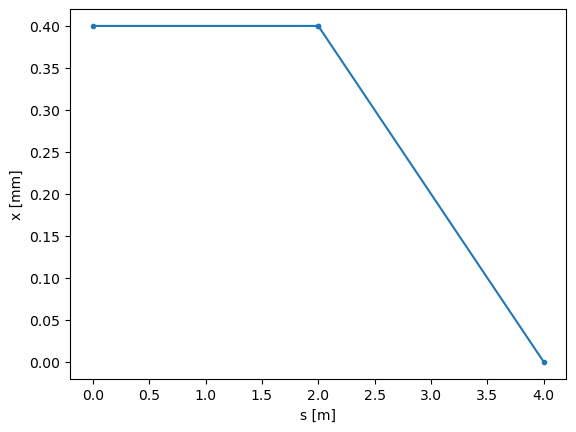

In [8]:
# Let's make a simple plot
plt.plot(tracked_data["s"], tracked_data["x"], ".-")
plt.xlabel("s [m]")
plt.ylabel("x [mm]")

We can also repeat this for many particles: the phase-space coordinates of several, say $N$, particles can be conveniently collected in a $2 \times N$ matrix:
\begin{equation}
X = \left[ 
    \left(
    \begin{array}{c}
    x \\
    x'
    \end{array}
    \right)_1
    \left(
    \begin{array}{c}
    x \\
    x'
    \end{array}
    \right)_2
    \left(
    \begin{array}{c}
    x \\
    x'
    \end{array}
    \right)_3
    \cdots
    \left(
    \begin{array}{c}
    x \\
    x'
    \end{array}
    \right)_N
\right]
\end{equation}

This is very convenient, as we can then transport all particles through the very same matrix multiplication: 
\begin{equation}
X_s = M_n \cdot ... \cdot M_2 \cdot M_1 \cdot X_0
\end{equation}
where $X_0$ are the initial coordinates, and $X_s$ the final ones. 

**Example:** let's describe $N=5$ particles all with initial angle $x'_0=0$, but different initial $x_0$, e.g. [-2,-1,0,1,2] mm

In [9]:
# Let's define all initial conditions in a matrix:
X_0 = np.array( [ [-2, -1, 0, 1, 2], 
                  [ 0,  0, 0, 0, 0] ] )
print(X_0)

[[-2 -1  0  1  2]
 [ 0  0  0  0  0]]


> 🔹 **NOTE:** the first `row` contains all `x` coordinates for all particles, while the second `row` contains all `x'` coordinates.

As before, we can use our tools to track all particles along the given beamline:

Text(0, 0.5, 'x [mm]')

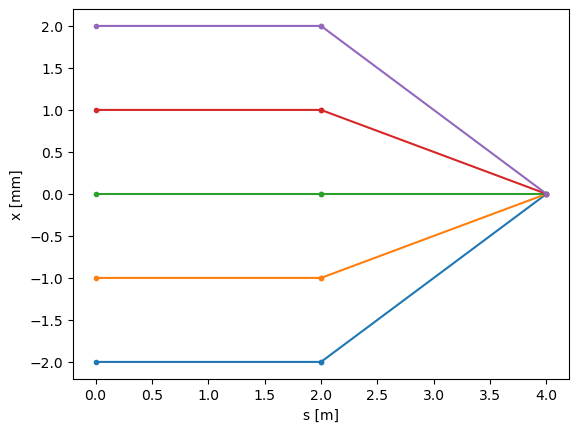

In [10]:
tracked_data = transportParticles(X_0, beamline)
plt.plot(tracked_data["s"], tracked_data["x"], ".-")
plt.xlabel("s [m]")
plt.ylabel("x [mm]")

We can also plot all final `x` coordinates as a function of the initial ones...

> 👀 **HINT (Python)**: Mind that `tracked_data['x']` is **NxM** `numpy` array, where **N** are the number of elements along the beamline + 1 (the initial condition), and **M** are the number of particles being tracked.
E.g. 

❓ **QUESTION: What is the final position ($x_1$)? Why?**

Text(0, 0.5, 'Final x_1 [mm]')

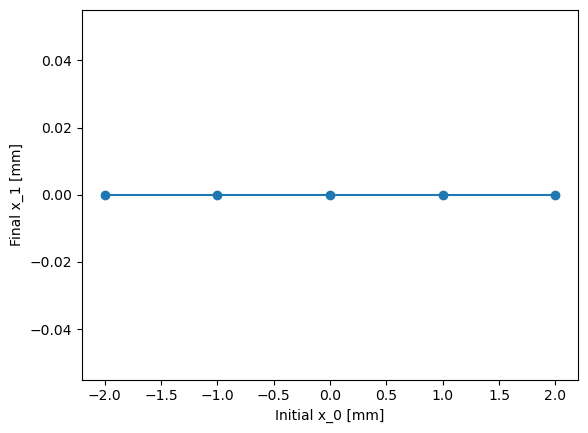

In [11]:
# Mind that tracked_data['x'][0,:] are the initial (0) `x` coordinate of all particles (:)
# and tracked_data['x'][-1,:] are the final (-1) `x` coordinate of all particles (:)
plt.plot(tracked_data["x"][0, :], tracked_data["x"][-1, :], "o-")
plt.xlabel("Initial x_0 [mm]")
plt.ylabel("Final x_1 [mm]")

## 📝 Exercise 1.2: Modifying a beamline
Now is your turn! Try to modify the beamline description: what happens if you modify your beam line such that $f \ne L$?


Text(0, 0.5, 'Final x_1 [mm]')

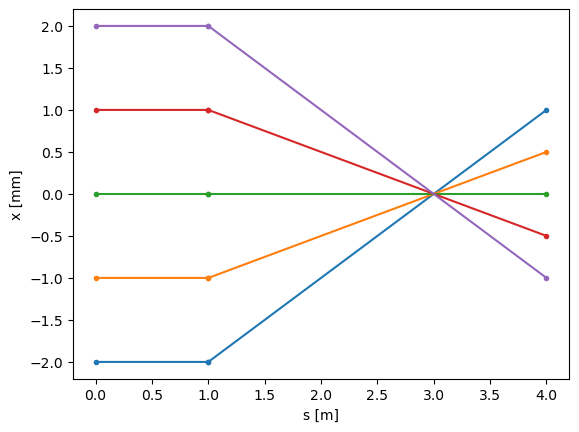

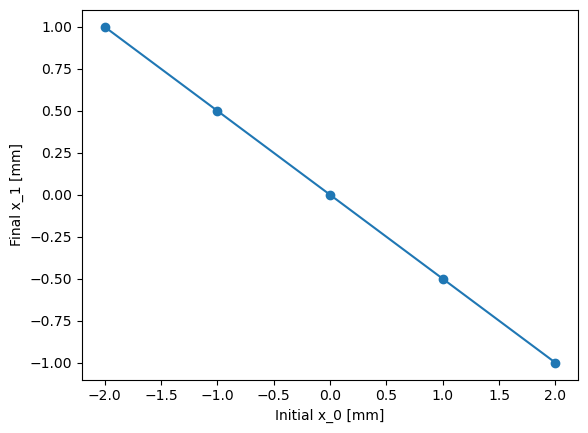

In [12]:
# Particles definition:
X_0 = np.array([ [-2, -1, 0, 1, 2], 
                 [ 0,  0, 0, 0, 0] ])
# Beamline definition:
f = 2  # [m]
L1 = 1  # [m]
L2 = 3  # [m]
beamline = D(L1) + Q(f) + D(L2)

# tracking
tracked_data = transportParticles(X_0, beamline)

# plotting
plt.figure()
plt.plot(tracked_data["s"], tracked_data["x"], ".-")
plt.xlabel("s [m]")
plt.ylabel("x [mm]")

# plotting
plt.figure()
plt.plot(tracked_data["x"][0, :], tracked_data["x"][-1, :], "o-")
plt.xlabel("Initial x_0 [mm]")
plt.ylabel("Final x_1 [mm]")

> 🔹 **NOTE:** Clearly, if we go away from the L=f condition, the final *x* coordinates are not zero anymore.

## 📝 Exercise 1.3: Trancuating drifts to improve beamline plotting

Let's consider again the beamline from [First Guided Exercise](#first-guided-exercise), i.e. a quadrupole in between drifts such that $f=L=2.5$ in this case, however, model the drifts as a series of $L/10$ long drifts.

1. Track all particles along the newly defined beamline, note that this allows to have "more points" along $s$ to see the trajectory of your particles.
2. Verify once more that parallel rays (e.g. $x_0$ = [-2,-1,0,1,2] mm) cross the axis after a distance $L=f$ after the quadrupole, plotting the final $x$ as a function of the initial one for all particles. **Anything strange to observe?**

> **👀 HINT (Python)**: given our beamline element modelling as a list, you can repeat a single element *N* times, simply by multiplying it by *N*, e.g. to model 5 equal drifts of 3 m each one can simply do `5*D(3)`.

Text(0, 0.5, 'Final x_1 [mm]')

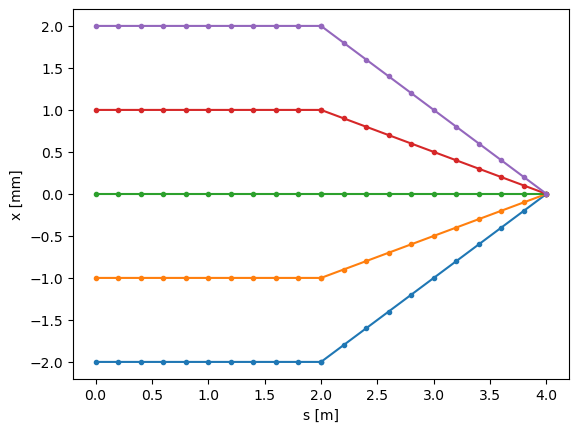

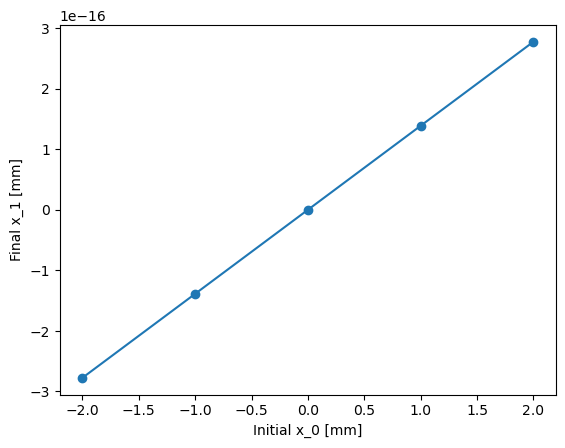

In [13]:
# Particles definition:
X_0 = np.array([ [-2, -1, 0, 1, 2], 
                 [ 0,  0, 0, 0, 0] ])

# Beamline definition:
f = 2  # [m]
# NOTE! You can repeat one element s
beamline = 10 * D(f / 10) + Q(f) + 10 * D(f / 10)

# tracking
tracked_data = transportParticles(X_0, beamline)

# plotting as a function of s along the beamline
plt.figure()
plt.plot(tracked_data["s"], tracked_data["x"], ".-")
plt.xlabel("s [m]")
plt.ylabel("x [mm]")

# plotting of final x coordinate as a function of initial one
plt.figure()
plt.plot(tracked_data["x"][0, :], tracked_data["x"][-1, :], "o-")
plt.xlabel("Initial x_0 [mm]")
plt.ylabel("Final x_1 [mm]")
# Note the exponents on the y-axis... what is this?!?!

> 🔹 **NOTE:** for us, in this hands-on course, this means 0... But for accurate simulations, one has to be careful with numerical precision! See the [Computational Tools](https://indico.cern.ch/event/1226773/contributions/5161277/) lectures!!

## ⚛️ Physics focus: from a beamline to an equivalent single element

A beam line (or a whole ring) is modelled by a series of matrices. Independently of the initial particle coordinates, we can compute a single matrix ($M_{eq.}$) that represents the whole beam line (or ring): 

\begin{equation}
X_s = M_n \cdot ... \cdot M_2 \cdot M_1 \cdot X_0 = M_{eq.} \cdot X_0
\end{equation}

Given our choice of beamline structure, i.e. a `list` of **elements**, each modeled by a `dictionary` with some properties, another help function is provided in the `tracking_library` toolbox that does exaly that:

In [14]:
# import the getEquivalentElement function
from tracking_library import getEquivalentElement

# Beamline definition, e.g. two drifts of 1.3 and 0.6 m:
beamline = D(1.3) + D(0.6)

# Compute equivalent element, or "one-turn-matrix"
equivalent_element = getEquivalentElement(beamline)
print(equivalent_element)

[{'matrix': array([[1. , 1.9],
       [0. , 1. ]]), 'length': 1.9}]


> 🔹 **NOTE:** Indeed, this corresponds to the matrix of a drift of lenght L=1.3+0.6=1.9 m

## 📝 Exercise 1.4: Equivalent matrix

Compute the equivalent matrix of a beamline made of two consecutive thin quadrupoles with **different focal length ($f_1 = 1$ and $f_2 = 2$)**. 

❓ **QUESTION: What does the final matrix resamble to?**

In [15]:
# let's define the focal lengths in two variables
f1 = 1
f2 = 2

# Beamline definition made of the two quadrupoles
beamline = Q(f1) + Q(f2)

# Compute equivalent element, or "one-turn-matrix"
equivalent_element = getEquivalentElement(beamline)
print(equivalent_element)

[{'matrix': array([[ 1. ,  0. ],
       [-1.5,  1. ]]), 'length': 0}]


> 🔹**NOTE:** Since there is no drift between the two quadrupoles, this is equivalent to a quadrupole with focal length such that $1/f = 1/f1 + 1/f2$ ! This means that **if you "split" a quadrupole in two**, you end up with two quadrupoles with **double the focal length** of the original one.


## 📝 Exercise 1.5: Explore your own beamlines

Your time to explore...
1. Build a more complex beamline made of several (be reasonable) quadrupoles with different focal lengths (possibly, alternating positive and negative *f*) and drifts (possibly, split them in many short drifts). 
2. Track a bunch of *N* particles (be reasonable on *N*...) with initial random coordinates (say, 2 mm, 3 mrad rms), and plot all their *x* trajectory along *s*

> 🔹 **NOTE:** Try to keep the particles oscillation amplitude "small" varying the strength/focal length of your quadrupoles.

> 👀 **HINT (Python)**: Remember that you can repeat one element *but also a full portion of beamline* simply with the * operation.

### Solution for 1. 

In [16]:
# Let's make a long beamline:
beamline = 5 * (10 * D(0.5 / 10) + Q(1) + 10 * D(2 / 10) + Q(-0.8) + 10 * D(1.5 / 10) + Q(0.3) + +10 * D(1.5 / 10))

### Solution for 2. 

Text(0, 0.5, 'x [mm]')

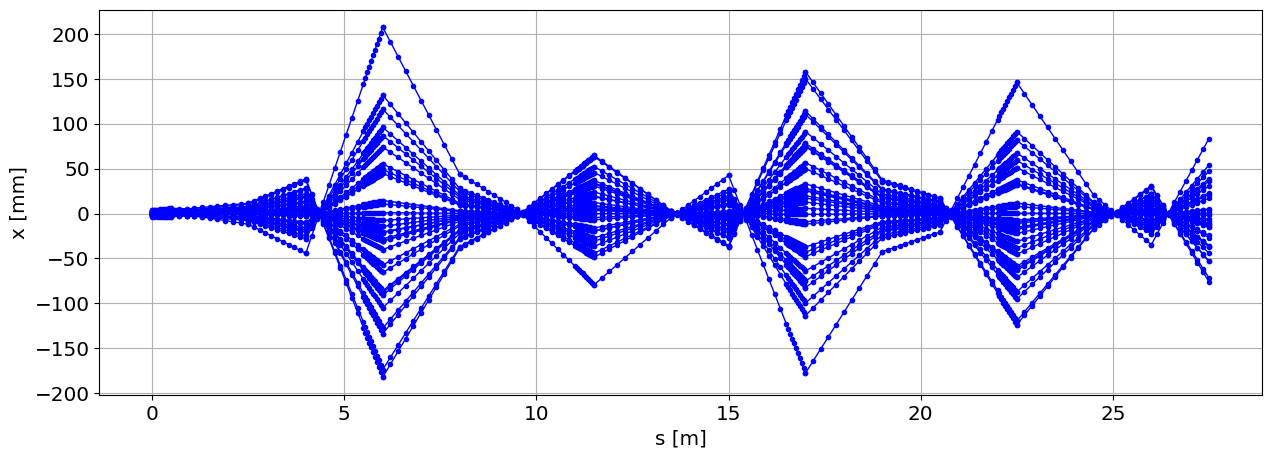

In [21]:
# define several particles with a random angle and zero position
n_particles = 30
X = np.array([ 2 * np.random.randn(n_particles), 
               3 * np.random.randn(n_particles) ])
# track the particles and plot the output
transported_particles = transportParticles(X, beamline)

plt.plot(transported_particles["s"], transported_particles["x"], "b.-", lw=1)
plt.grid(True)
plt.xlabel("s [m]")
plt.ylabel("x [mm]")

> 🔹 **NOTE:** it is not so easy to keep the amplitude of the oscillations bounded to reasonable values! **We will need to develop smarter methods to properly choose the elements in a beamline...**

# Well done ! Now you have the basic ingredients !

Now you understand how to transport an ensamble of particles or its **covariance** matrix along a beamline... But how to design a "nice" beamline?

=> **Continue your learning with the following [notebook](./02_Multi_Particles.ipynb)**...

> 🔹 **NOTE:** If you have time and wish to, consider also looking at the optional exercises.
